# Contrastive Financial Embeddings

## Context
Off-the-shelf text embeddings (NB02) capture general semantics but aren't optimized for financial signal. Contrastive learning fine-tunes embeddings so that texts about stocks with similar returns are close together, and texts about diverging stocks are far apart.


## Pipeline
Financial headlines + stock returns → Contrastive pairs (same return quintile = positive, different = negative) → Fine-tune encoder → Financial-signal-optimized embeddings

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

## 1. Create Training Data
We need (headline, stock_return) pairs. The contrastive loss will learn embeddings where stocks with similar returns have similar headline embeddings.

In [2]:
np.random.seed(42)

data = []
# Generate headlines with implicit sentiment → return correlation
templates_positive = [
    "{company} reports record quarterly revenue exceeding analyst expectations",
    "{company} announces major partnership deal to expand market reach",
    "{company} beats earnings estimates by wide margin in Q4",
    "{company} raises full-year guidance citing strong demand",
    "{company} wins major government contract worth $2 billion",
    "{company} launches innovative product to strong customer reception",
    "{company} expands into new markets with strategic acquisition",
    "{company} reports surge in subscriber growth beating all estimates",
]
templates_negative = [
    "{company} misses revenue expectations amid weakening demand",
    "{company} announces layoffs affecting 10% of workforce",
    "{company} faces regulatory investigation over business practices",
    "{company} warns of lower guidance citing supply chain issues",
    "{company} reports unexpected quarterly loss shocking analysts",
    "{company} recalls products due to safety concerns",
    "{company} loses market share to competitors in core business",
    "{company} under pressure as key customers reduce orders",
]
templates_neutral = [
    "{company} reports quarterly results in line with expectations",
    "{company} maintains steady operations in challenging environment",
    "{company} announces leadership transition as CEO retires",
    "{company} completes previously announced restructuring plan",
]

companies = [
    "Acme Corp",
    "Beta Inc",
    "Gamma Tech",
    "Delta Health",
    "Epsilon Energy",
    "Zeta Finance",
    "Eta Retail",
    "Theta Pharma",
    "Iota Systems",
    "Kappa Media",
    "Lambda Auto",
    "Mu Logistics",
    "Nu Biotech",
    "Xi Mining",
    "Omicron Telecom",
]

for company in companies:
    # Positive headlines → higher returns
    for template in np.random.choice(templates_positive, size=3, replace=False):
        ret = np.random.normal(0.05, 0.02)  # positive return
        data.append({
            "company": company,
            "headline": template.format(company=company),
            "return": ret,
            "quintile": None,
        })
    # Negative headlines → lower returns
    for template in np.random.choice(templates_negative, size=3, replace=False):
        ret = np.random.normal(-0.05, 0.02)
        data.append({
            "company": company,
            "headline": template.format(company=company),
            "return": ret,
            "quintile": None,
        })
    # Neutral headlines → near-zero returns
    for template in np.random.choice(templates_neutral, size=2, replace=False):
        ret = np.random.normal(0.0, 0.02)
        data.append({
            "company": company,
            "headline": template.format(company=company),
            "return": ret,
            "quintile": None,
        })

df = pd.DataFrame(data)
# Assign quintiles based on returns
df["quintile"] = pd.qcut(df["return"], q=5, labels=[0, 1, 2, 3, 4]).astype(int)

print(f"Dataset: {len(df)} headlines, {df['company'].nunique()} companies")
print(f"\nReturn distribution by quintile:")
print(df.groupby("quintile")["return"].agg(["mean", "std", "count"]).to_string())


Dataset: 120 headlines, 15 companies

Return distribution by quintile:
              mean       std  count
quintile                           
0        -0.065690  0.011900     24
1        -0.034066  0.008145     24
2         0.004237  0.010839     24
3         0.034606  0.007875     24
4         0.063262  0.011297     24


In [3]:
df.head()

,company,headline,return,quintile
0,Acme Corp,Acme Corp announces major partnership deal to ...,0.045317,3
1,Acme Corp,Acme Corp launches innovative product to stron...,0.045317,3
2,Acme Corp,Acme Corp reports record quarterly revenue exc...,0.081584,4
3,Acme Corp,Acme Corp misses revenue expectations amid wea...,-0.034651,1
4,Acme Corp,Acme Corp faces regulatory investigation over ...,-0.059268,0


## 2. Baseline: Off-the-Shelf Embeddings
Before fine-tuning, see how well vanilla embeddings cluster by return quintile.

In [4]:
# Generate baseline embeddings
from sentence_transformers import SentenceTransformer

st = SentenceTransformer(
    "all-miniLM-L6-v2",
    prompts={"retrieval": "Retrieve semantically similar text: "},
)

embeddings = st.encode(df["headline"])

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-miniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [5]:
embeddings.shape, embeddings.dtype

((120, 384), dtype('float32'))

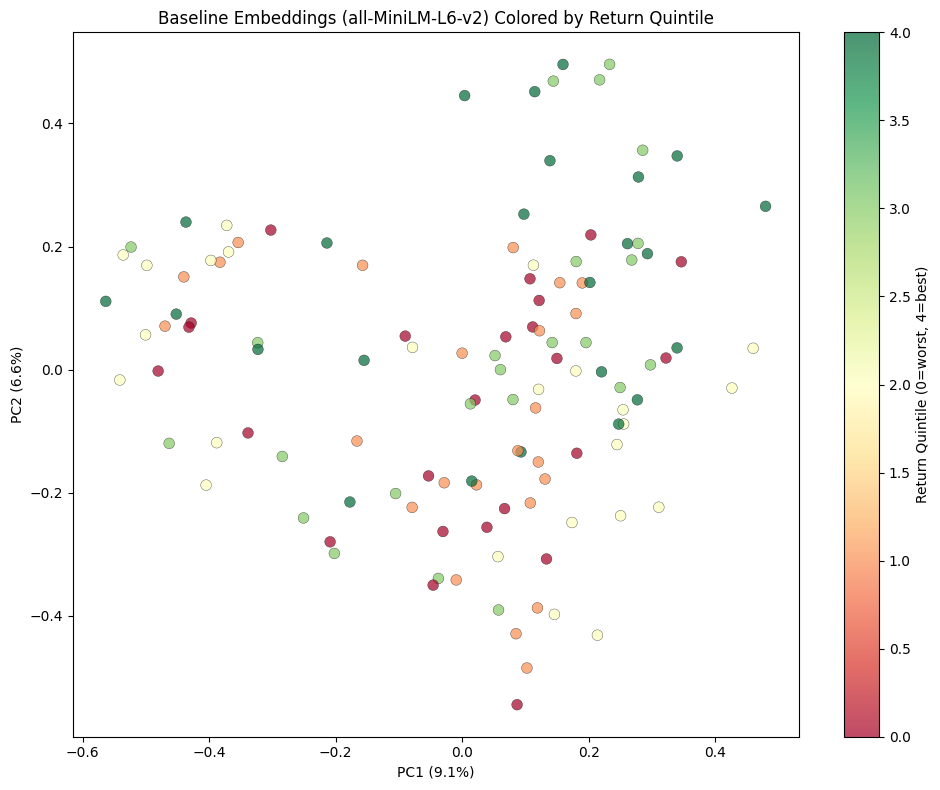

In [6]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
components = pca.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    components[:, 0],
    components[:, 1],
    c=df["quintile"],
    cmap="RdYlGn",
    alpha=0.7,
    s=60,
    edgecolors="black",
    linewidth=0.3,
)
plt.colorbar(scatter, label="Return Quintile (0=worst, 4=best)")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
ax.set_title("Baseline Embeddings (all-MiniLM-L6-v2) Colored by Return Quintile")
plt.tight_layout()
plt.show()

## 3. Contrastive Learning Setup
We use a simple contrastive loss: minimize distance between same-quintile pairs, maximize distance between different-quintile pairs.

In [ ]:
from torch import nn
import torch.nn.functional as F
from jaxtyping import Float
from torch import Tensor

# class ContrastivePairDataset(Dataset):
#     """
#     Each item will be an ((embedding, embedding), {0,1}) pair
#     Positive pairs: same quintile
#     Negative pairs: different quintile
#     """

#     def __init__(self, embeddings, quintiles, n_pairs=1000):
#         self.n_pairs = n_pairs
#         self.embeddings = embeddings
#         self.quintiles = quintiles

#     def __len__(self):
#         return self.n_pairs

#     def __getitem__(self, idx):
#         i, j = np.random.choice(len(self.embeddings), 2, replace=False)
#         emb1, emb2 = self.embeddings[i, :], self.embeddings[j, :]
#         positive = int(self.quintiles[i] == self.quintiles[j])
#         return ((emb1, emb2), positive)


class InfoNCEDataset(Dataset):
    """
    Each item will be an ((embedding, embedding), {0,1}) pair
    Positive pairs: same quintile
    Negative pairs: different quintile
    """

    def __init__(self, embeddings: np.ndarray, quintiles: np.ndarray):
        super().__init__()
        self.embeddings: float[Tensor, "n d"] = torch.tensor(
            embeddings, dtype=torch.float32
        )
        self.quintiles: int[Tensor, "n"] = torch.tensor(quintiles, dtype=torch.long)

    def __len__(self) -> int:
        return len(self.embeddings)

    def __getitem__(self, idx: int):
        return self.embeddings[idx], self.quintiles[idx]


class ProjectionHead(nn.Module):
    """Small projection head to fine-tune embedding space."""

    def __init__(self, input_dim=384, hidden_dim=128, output_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x: Float[Tensor, "batch d_in"]) -> Float[Tensor, "batch d_out"]:
        x = self.net(x)
        x = F.normalize(x, dim=-1)
        return x


class InfoNCELoss(nn.Module):
    """Contrastive loss with InfoNCE."""

    def __init__(self, margin=0.5, temperature=1.0):
        super().__init__()
        self.temperature: float = temperature

    def forward(
        self, embeddings: float[Tensor, "batch d"], quintiles: int[Tensor, "batch"]
    ):
        """
        contrastive loss:
        loss = -log(exp(sim(z_i, z_j) / tau) / sum_k exp(sim(z_i, z_k) / tau))
        """
        pass


## 4. Train the Projection Head

In [ ]:
# Create dataset and dataloader

# TODO: implement
...

## 5. Compare: Baseline vs Contrastive Embeddings

In [ ]:
# Project embeddings through trained projection head

# TODO: implement
...

## 6. Quantitative Evaluation

In [ ]:
def avg_similarity_by_group(embeddings, labels):
    """Compute average cosine similarity for same-group and different-group pairs."""
    ...


## Discussion & Interview Talking Points

### Connection to My Experience
- **Creyon Bio**: Used contrastive learning on 3D electrostatic maps to predict oligo toxicity. Pushed AUC from 0.73 to 0.88.
- **Same framework**: Instead of electrostatic maps → toxicity, we have financial text → returns. The contrastive objective is identical.
- **DPO experience**: My recent DPO fine-tuning work (Qwen 32B) uses a similar preference-based optimization — DPO is conceptually a contrastive method.

### Strengths
- **Domain-adapted**: Embeddings are optimized for the actual downstream task (return prediction)
- **Beyond sentiment**: Captures whatever textual patterns correlate with returns, not just positive/negative
- **Composable**: Can use contrastive embeddings as input to any downstream model

### Weaknesses & Considerations
- **Requires labeled data**: Need (text, return) pairs, which means historical market data
- **Temporal leakage risk**: Must use strict temporal train/test splits
- **Overfitting**: With small datasets, the projection head can memorize rather than generalize

### For Numerai
- Contrastive embeddings trained on returns that have been **factor-neutralized** would directly optimize for Numerai's scoring metric
- Could combine with graph features (NB04): contrastive loss where graph-neighbors should have similar embeddings

### Extensions (TODO)
- [ ] Use triplet loss instead of pairwise contrastive
- [ ] Fine-tune the encoder itself (not just a projection head) with LoRA
- [ ] Train on factor-neutralized returns for Numerai-specific optimization
- [ ] Add hard negative mining (most confusing cross-quintile pairs)
- [ ] Compare InfoNCE, NT-Xent, and supervised contrastive losses